In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from pathlib import Path


In [6]:
def convert_openbci_txt_to_csv(txt_path: str, csv_path: str) -> None:
    """
    Reads an OpenBCI raw data text file (with '%' comment headers) and
    writes the numerical data to a plain CSV file.

    Parameters
    ----------
    txt_path : str
        Path to the input .txt file
    csv_path : str
        Path where the output .csv should be saved
    """
    # pandas will skip any line that starts with '%' and then parse the first non-comment
    # line as header and the rest as data
    df = pd.read_csv(txt_path, comment='%', sep=',')
    # write out without the pandas index
    df.to_csv(csv_path, index=False)
    print(f"Converted '{txt_path}' → '{csv_path}' ({df.shape[0]} rows, {df.shape[1]} columns)")

# Example usage:
if __name__ == "__main__":
    convert_openbci_txt_to_csv('Data/OpenBCI-RAW-2025-05-17_10-25-52.txt', 'Data/OpenBCI-RAW-2025-05-17_10-25-52.csv')

Converted 'Data/OpenBCI-RAW-2025-05-17_10-25-52.txt' → 'Data/OpenBCI-RAW-2025-05-17_10-25-52.csv' (799 rows, 25 columns)


In [97]:
def plot_exg_since_start(csv_path: str, start_time: float = 0.0):
    """
    Reads a CSV from OpenBCI, parses the correct timestamp column,
    computes elapsed time since start, filters to start_time,
    and plots all EXG channels vs. elapsed seconds without scientific notation.
    """
    # 1) Load and clean column names
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # 2) Parse the right timestamp column
    if 'Timestamp (Formatted)' in df.columns:
        ts = pd.to_datetime(df['Timestamp (Formatted)'])
    elif 'Timestamp' in df.columns:
        ts = pd.to_datetime(df['Timestamp'], unit='s')
    else:
        raise KeyError(f"No timestamp column found; available columns: {df.columns.tolist()}")

    # 3) Compute elapsed time in seconds
    df['Elapsed (s)'] = (ts - ts.iloc[0]).dt.total_seconds()

    # 4) Filter to start_time onward
    df = df[df['Elapsed (s)'] >= start_time]

    # 5) Identify EXG channel columns
    exg_cols = [c for c in df.columns if c.startswith('EXG Channel')]
    if not exg_cols:
        raise KeyError(f"No EXG channels found; available columns: {df.columns.tolist()}")

    # 6) Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    for ch in exg_cols:
        ax.plot(df['Elapsed (s)'], df[ch], label=ch)

    # 7) Label and format
    ax.set_xlabel('Time Since Start (s)')
    ax.set_ylabel('EXG Signal Value (µV)')
    ax.set_title(f"EXG Channels vs. Elapsed Time (from {start_time}s)")
    ax.legend(loc='upper right')
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.tight_layout()
    return fig, ax

In [98]:
def plot_column_vs_elapsed_time(csv_path: str, column: str, start_time: float = 0.0):
    """
    Reads a CSV from OpenBCI, picks the correct timestamp column,
    computes elapsed time since start, filters to start_time,
    and plots the specified column vs. elapsed seconds.
    """
    # 1) load & clean column names
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # 2) pick/parse the timestamp series
    if 'Timestamp (Formatted)' in df.columns:
        ts = pd.to_datetime(df['Timestamp (Formatted)'])
    elif 'Timestamp' in df.columns:
        # numeric epoch-in-seconds → tell pandas unit='s'
        ts = pd.to_datetime(df['Timestamp'], unit='s')
    else:
        raise KeyError(f"No timestamp column found in {csv_path}")

    # 3) compute elapsed seconds
    df['Elapsed (s)'] = (ts - ts.iloc[0]).dt.total_seconds()

    # 4) filter out anything before start_time
    df = df[df['Elapsed (s)'] >= start_time]

    # 5) sanity-check the target column
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not in {csv_path}; available: {df.columns.tolist()}")

    # 6) plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df['Elapsed (s)'], df[column])
    ax.set_xlabel('Time Since Start (s)')
    ax.set_ylabel(column)
    ax.set_title(f"{column} vs. Elapsed Time (from {start_time}s)")

    # 7) force plain tick labels (no 1e2 offsets)
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.tight_layout()
    return fig, ax

In [54]:
df = pd.read_csv('Data/OpenBCI-RAW-2025-05-17_10-25-52.csv')
df

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Accel Channel 0,...,Digital Channel 2 (D13),Digital Channel 3 (D17),Not Used.1,Digital Channel 4 (D18),Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Marker Channel,Timestamp (Formatted)
0,65.0,32308.194912,21292.919969,-187500.022352,-187500.022352,187500.000000,-45084.787319,-187500.022352,-187500.022352,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:25:52.980
1,252.0,-58044.440513,-49185.550116,-59472.649929,106086.967121,-58011.874022,-57594.611656,-57750.515074,-57365.707441,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:25:52.980
2,142.0,-58107.070101,-49171.021482,-59480.316577,106039.134388,-58582.178781,-57599.171412,-57740.166216,-57345.277947,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:25:52.980
3,186.0,-58221.980419,-49034.988765,-59691.719376,106019.554260,-58106.488956,-57628.429845,-57763.814362,-57377.285645,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:25:52.980
4,187.0,-58365.389212,-49160.694976,-59135.496215,106033.412341,-58017.908993,-57595.505726,-57715.355780,-57368.702575,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:25:52.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,15.0,32534.193401,22116.291179,-187500.022352,-187500.022352,187500.000000,-41168.493470,-187500.022352,-187500.022352,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:26:52.589
795,219.0,33724.602607,22369.089409,-187500.022352,-187500.022352,187500.000000,-42903.346467,-187500.022352,-187500.022352,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:26:52.614
796,48.0,34244.861811,22017.250600,-187500.022352,-187500.022352,187500.000000,-41356.784565,-187500.022352,-187500.022352,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:26:52.614
797,13.0,33730.212895,22435.027055,-187500.022352,-187500.022352,187500.000000,-41443.844610,-187500.022352,-187500.022352,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747503e+09,0.0,2025-05-17 10:26:52.673


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'EXG Channels vs. Elapsed Time (from 0.0s)'}, xlabel='Time Since Start (s)', ylabel='EXG Signal Value (µV)'>)

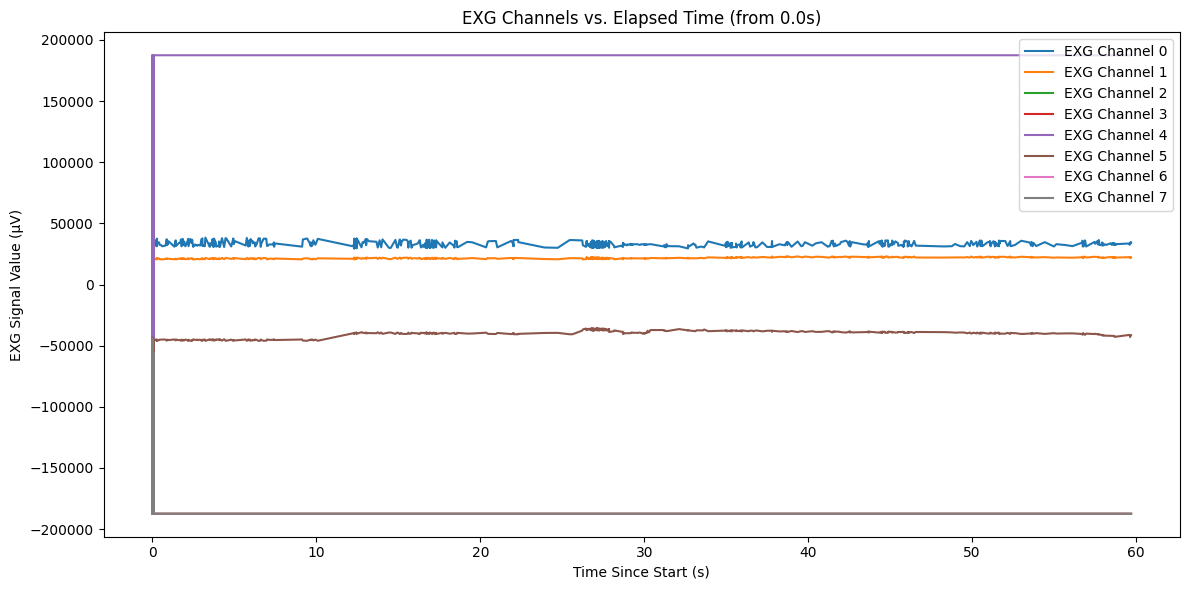

In [99]:
plot_exg_since_start('Data/OpenBCI-RAW-2025-05-17_10-25-52.csv')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'EXG Channel 0 vs. Elapsed Time (from 1.0s)'}, xlabel='Time Since Start (s)', ylabel='EXG Channel 0'>)

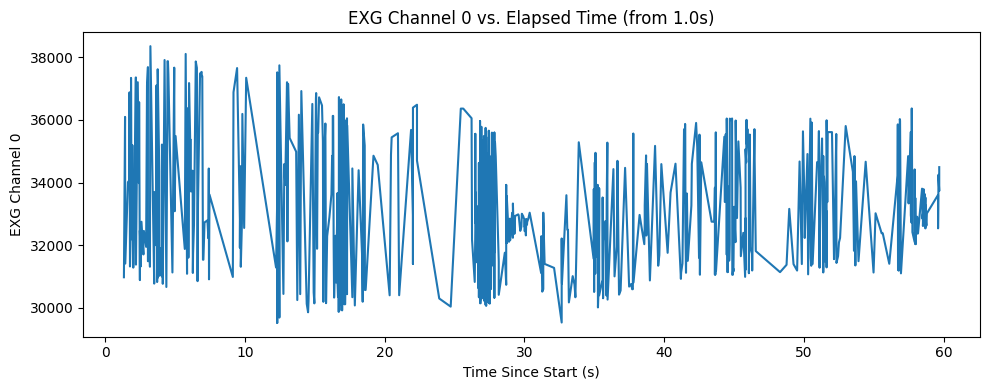

In [100]:
plot_column_vs_elapsed_time('Data/OpenBCI-RAW-2025-05-17_10-25-52.csv','EXG Channel 0',1.0)

In [58]:
convert_openbci_txt_to_csv('Data/OpenBCI-RAW-2025-05-17_11-23-28.txt', 'Data/OpenBCI-RAW-2025-05-17_11-23-28.csv')

Converted 'Data/OpenBCI-RAW-2025-05-17_11-23-28.txt' → 'Data/OpenBCI-RAW-2025-05-17_11-23-28.csv' (27450 rows, 25 columns)


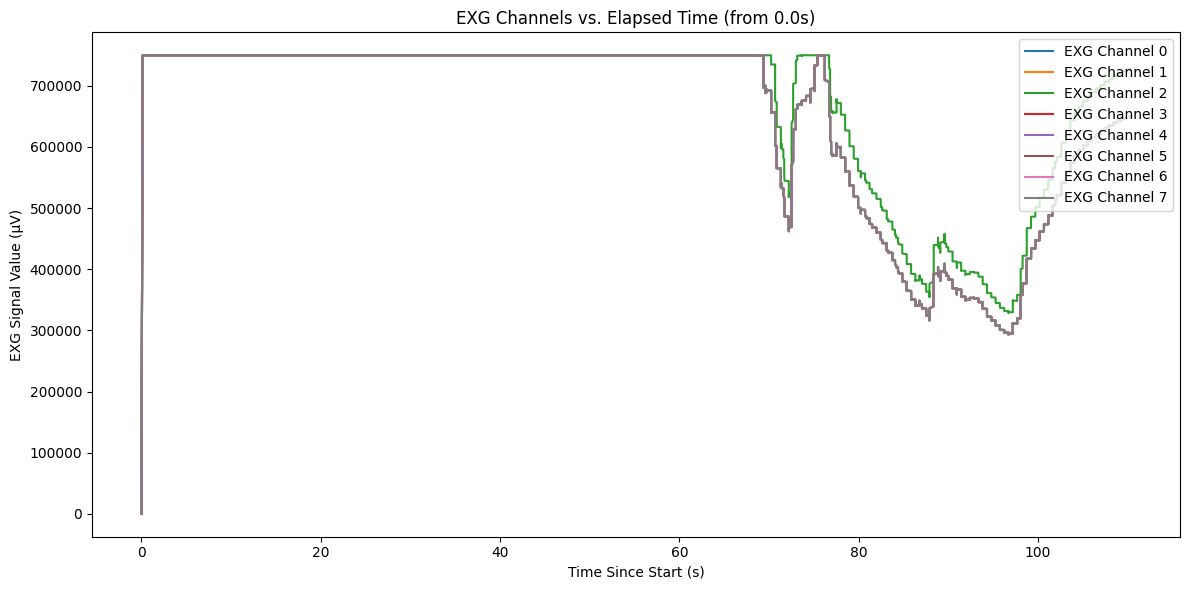

In [59]:
plot_exg_since_start('Data/OpenBCI-RAW-2025-05-17_11-23-28.csv')

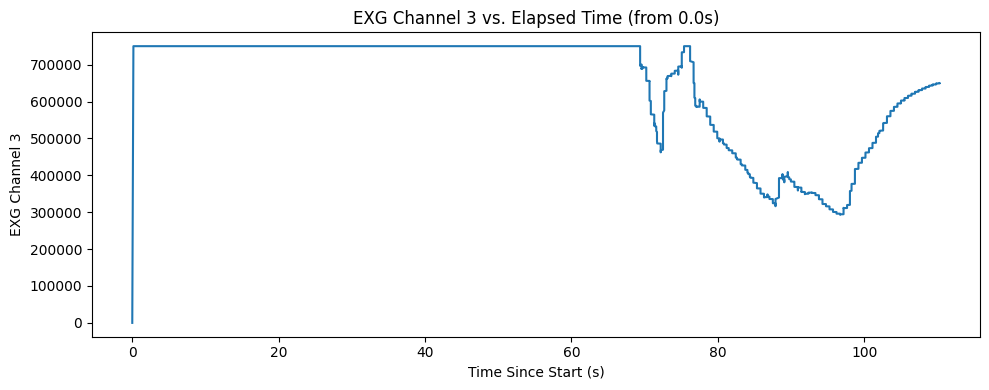

In [63]:
plot_column_vs_elapsed_time('Data/OpenBCI-RAW-2025-05-17_11-23-28.csv','EXG Channel 3')

In [104]:
'''
Band pass filters with Butterworth filter
Order = 5
Sampling frequency(fs) = 250 Hz
Nyquist frequency(low, high) = 0.5 * fs
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a) * data[0]
    y, _ = lfilter(b, a, data, zi=zi)
    return y

'''
EEG band pass spectrum:
Delta --> >0.5 Hz and < 4 Hz
Theta --> >4 Hz and < 8 Hz
Alpha --> >8 Hz and < 13 Hz
Beta --> >13 Hz and < 32 Hz
Gamma --> >32 Hz and < 100 Hz
'''


def filter_and_save(csv_in: str, csv_out: str,
                    channel: str = 'EXG Channel 1',
                    fs: int = 250,
                    order: int = 3):
    """
    Reads csv_in, applies delta/theta/alpha/beta/gamma band-pass filters
    to `channel`, and writes a new CSV with:
      Elapsed (s), raw signal, delta, theta, alpha, beta, gamma
    """
    # 1) load & normalize colnames
    df = pd.read_csv(csv_in)
    df.columns = df.columns.str.strip()

    # 2) optionally rename so you can do df.Fp2 — uncomment if you want:
    # df.rename(columns={channel: 'Fp2'}, inplace=True)
    # channel = 'Fp2'

    if channel not in df.columns:
        raise KeyError(f"Channel '{channel}' not found; "
                       f"available: {df.columns.tolist()}")

    # 3) build elapsed time column
    # prefer formatted timestamp if present
    if 'Timestamp (Formatted)' in df.columns:
        ts = pd.to_datetime(df['Timestamp (Formatted)'])
    else:
        ts = pd.to_datetime(df['Timestamp'], unit='s')
    df['Elapsed (s)'] = (ts - ts.iloc[0]).dt.total_seconds()

    # 4) grab the raw signal array
    raw = df[channel].values

    # 5) apply each band-pass
    bands = {
        'delta': (0.5, 4),
        'theta': (4,   8),
        'alpha': (8,  13),
        'beta':  (13, 32),
        'gamma': (32, 100),
    }
    out = {
        'Elapsed (s)': df['Elapsed (s)'],
        'raw':         raw,
    }
    for name, (low, high) in bands.items():
        out[name] = butter_bandpass_filter(raw, low, high, fs, order)

    # 6) assemble & save
    out_df = pd.DataFrame(out)
    out_df.to_csv(csv_out, index=False)
    print(f"Saved filtered data ({out_df.shape[0]}×{out_df.shape[1]}) → {csv_out}")

def plot_filtered_signals(csv_path: str):
    """
    Reads the filtered CSV (with columns Elapsed (s), raw, delta, theta, alpha, beta, gamma)
    and plots each series vs. elapsed time.
    """
    # load & clean
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # check for elapsed column
    if 'Elapsed (s)' not in df.columns:
        raise KeyError("Expected 'Elapsed (s)' in columns, got: " + ", ".join(df.columns))
    
    # find all signal columns (everything except elapsed)
    sig_cols = [c for c in df.columns if c != 'Elapsed (s)']

    # create the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    for col in sig_cols:
        ax.plot(df['Elapsed (s)'], df[col], label=col)

    ax.set_xlabel('Time Since Start (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Filtered EEG Bands and Raw Signal')
    ax.legend(loc='upper right')
    fig.tight_layout()

    return fig, ax

In [118]:
def plot_bands_all_channels(csv_path: str,
                            start_time: float = 0.0,
                            fs: int = 250,
                            order: int = 3):
    """
    Returns (fig, axes) with one subplot per EEG band (Delta, Theta, Alpha,
    Beta, Gamma), each showing all EXG channels (hue = channel) vs. elapsed time.
    """
    # 1) load & clean
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # 2) ensure elapsed time
    if 'Elapsed (s)' not in df.columns:
        # parse timestamp first
        if 'Timestamp (Formatted)' in df.columns:
            ts = pd.to_datetime(df['Timestamp (Formatted)'])
        else:
            ts = pd.to_datetime(df['Timestamp'], unit='s')
        df['Elapsed (s)'] = (ts - ts.iloc[0]).dt.total_seconds()
    df = df[df['Elapsed (s)'] >= start_time].reset_index(drop=True)

    # 3) find EXG channels
    exg_cols = [c for c in df.columns if c.startswith('EXG Channel')]
    if not exg_cols:
        raise KeyError("No EXG Channel columns found")

    # 4) band definitions
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4,   8),
        'Alpha': (8,  13),
        'Beta':  (13, 32),
        'Gamma': (32,100),
    }

    # 5) prep figure
    fig, axes = plt.subplots(len(bands), 1, sharex=True, figsize=(12, 3*len(bands)))
    for ax, (band, (low, high)) in zip(axes, bands.items()):
        for ch in exg_cols:
            raw = df[ch].values
            b, a = butter(order, [low/(0.5*fs), high/(0.5*fs)], btype='band')
            y, _ = lfilter(b, a, raw, zi=lfilter_zi(b, a)*raw[0])
            ax.plot(df['Elapsed (s)'], y, label=ch)
        ax.set_ylabel(f"{band} (µV)")
        ax.legend(loc='upper right', fontsize='small', ncol=2)
        ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    axes[-1].set_xlabel('Time Since Start (s)')
    plt.suptitle("EEG Bands by Channel", y=1.02)
    plt.tight_layout()
    return fig, axes

Saved filtered data (799×7) → Data/OpenBCI-RAW-2025-05-17_10-25-52_filtered.csv


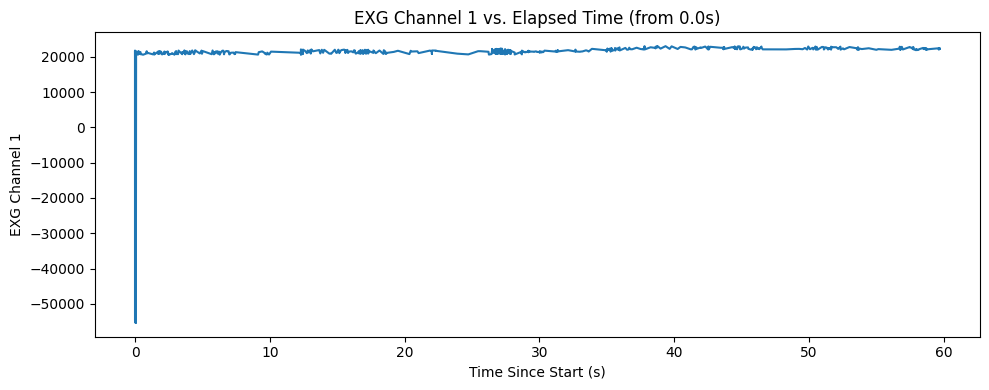

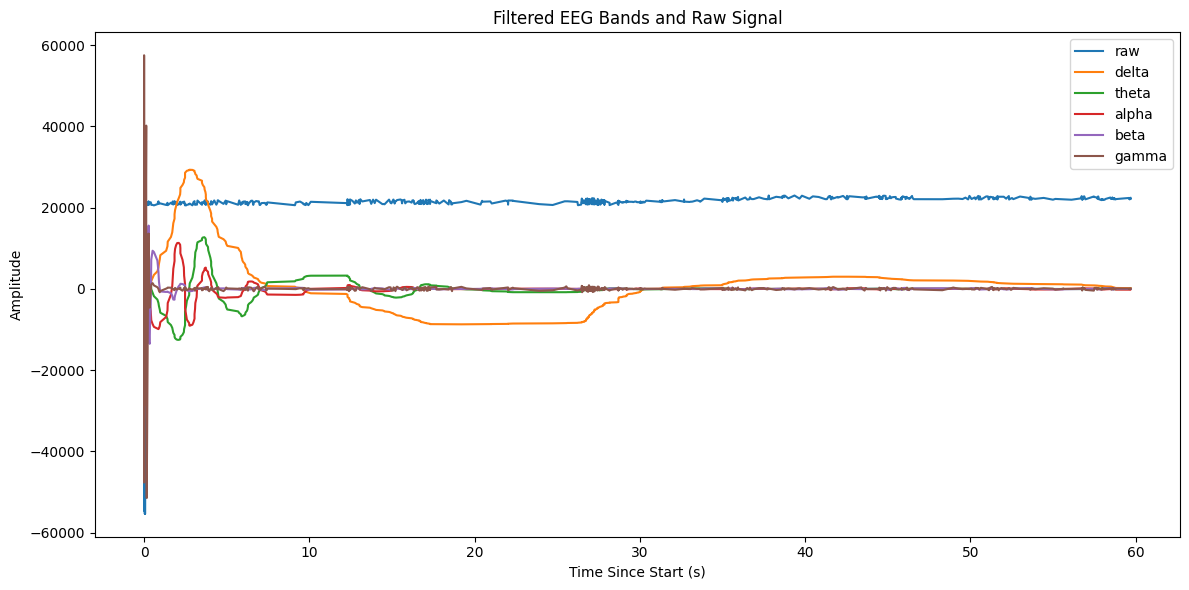

In [84]:
filter_and_save(
    'Data/OpenBCI-RAW-2025-05-17_10-25-52.csv',
    'Data/OpenBCI-RAW-2025-05-17_10-25-52_filtered.csv',
    channel='EXG Channel 1',
    fs=300,
    order=3
)
plot_column_vs_elapsed_time('Data/OpenBCI-RAW-2025-05-17_10-25-52.csv', 'EXG Channel 1')
plot_filtered_signals('Data/OpenBCI-RAW-2025-05-17_10-25-52_filtered.csv')

Converted 'Data/OpenBCI-RAW-2025-05-17_12-12-38.txt' → 'Data/OpenBCI-RAW-2025-05-17_12-12-38.csv' (20031 rows, 25 columns)


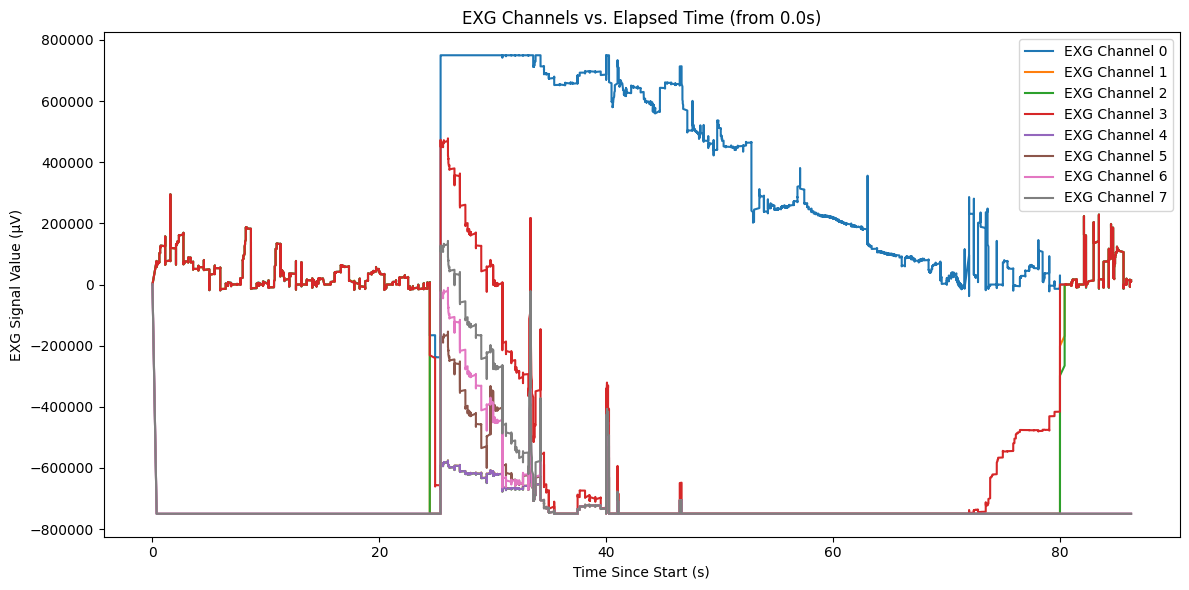

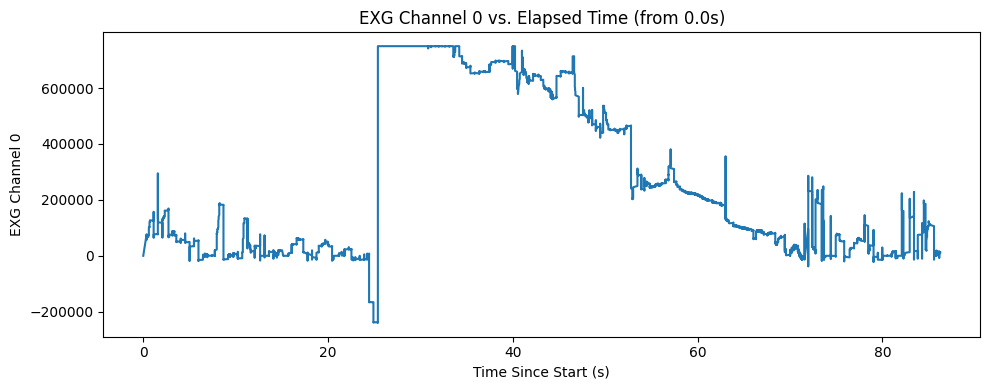

Saved filtered data (20031×7) → Data/OpenBCI-RAW-2025-05-17_12-12-38_filtered.csv


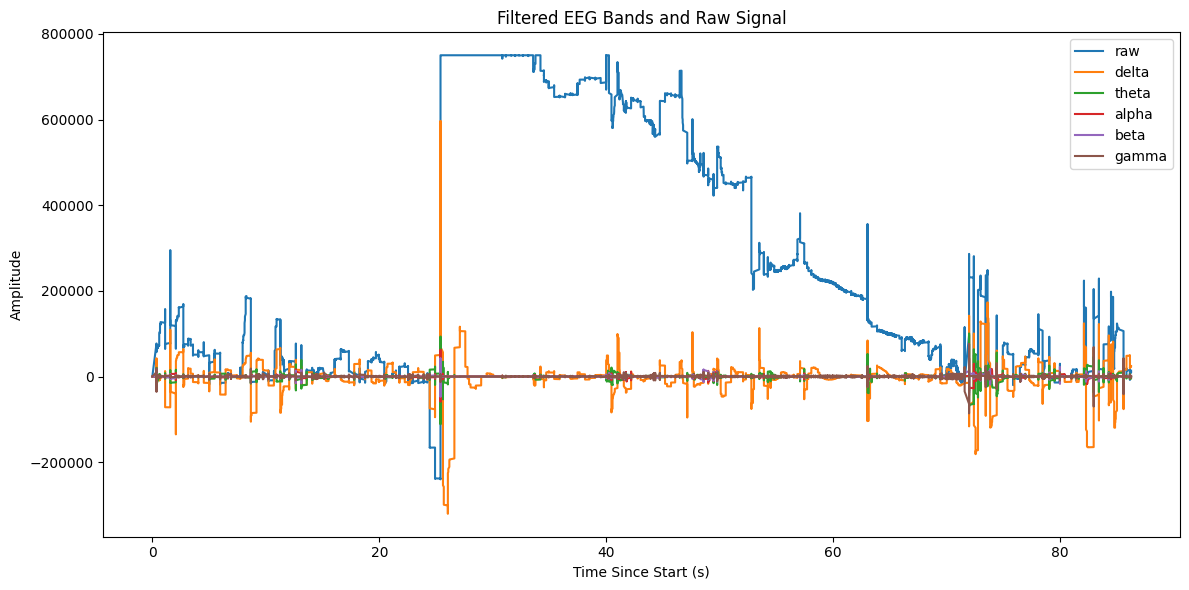

In [87]:
convert_openbci_txt_to_csv('Data/OpenBCI-RAW-2025-05-17_12-12-38.txt', 'Data/OpenBCI-RAW-2025-05-17_12-12-38.csv')
plot_exg_since_start('Data/OpenBCI-RAW-2025-05-17_12-12-38.csv')
plot_column_vs_elapsed_time('Data/OpenBCI-RAW-2025-05-17_12-12-38.csv', 'EXG Channel 0')
filter_and_save(
    'Data/OpenBCI-RAW-2025-05-17_12-12-38.csv',
    'Data/OpenBCI-RAW-2025-05-17_12-12-38_filtered.csv',
    channel='EXG Channel 0',
    fs=300,
    order=3
)
plot_filtered_signals('Data/OpenBCI-RAW-2025-05-17_12-12-38_filtered.csv')

In [119]:
def batch_process(input_folder: str, output_folder: str):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    for txt_path in input_folder.glob("*.txt"):
        name   = txt_path.stem
        subdir = output_folder / name
        subdir.mkdir(exist_ok=True)

        # → 1) convert to CSV
        csv_path = subdir / f"{name}.csv"
        convert_openbci_txt_to_csv(str(txt_path), str(csv_path))

        # → 2) all-channels plot
        fig, ax = plot_exg_since_start(str(csv_path))
        fig.savefig(subdir / f"{name}_exg_since_start.png")
        plt.close(fig)

        # → 3) per-channel plots
        for i in range(8):
            col = f"EXG Channel {i}"
            fig, ax = plot_column_vs_elapsed_time(str(csv_path), col)
            fig.savefig(subdir / f"{name}_channel_{i}.png")
            plt.close(fig)

        # → 4) filter & save CSVs
        filtered_paths = []
        for i in range(8):
            col = f"EXG Channel {i}"
            filtered_csv = subdir / f"{name}_channel_{i}_filtered.csv"
            filter_and_save(
                str(csv_path),
                str(filtered_csv),
                channel=col,
                fs=250,
                order=3
            )
            filtered_paths.append(filtered_csv)

        # → 5) plot filtered signals
        for filtered_csv in filtered_paths:
            base = filtered_csv.stem  # e.g. name_channel_0_filtered
            fig, ax = plot_filtered_signals(str(filtered_csv))
            fig.savefig(subdir / f"{base}.png")
            plt.close(fig)

        # 6) EEG bands plot
        fig, axes = plot_bands_all_channels(str(subdir / f"{name}.csv"),
                                            start_time=1.0,
                                            fs=250,
                                            order=3)
        fig.savefig(subdir / f"{name}_bands.png")
        plt.close(fig)

In [121]:
batch_process('Scare2_in/', 'Scare2_out/')

Converted 'Scare2_in/OpenBCI-RAW-2025-05-17_20-26-30.txt' → 'Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30.csv' (19679 rows, 25 columns)
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_0_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_1_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_2_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_3_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_4_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW-2025-05-17_20-26-30/OpenBCI-RAW-2025-05-17_20-26-30_channel_5_filtered.csv
Saved filtered data (19679×7) → Scare2_out/OpenBCI-RAW

Converted 'Data/OpenBCI-RAW-2025-05-17_18-35-41.txt' → 'Data/OpenBCI-RAW-2025-05-17_18-35-41.csv' (15602 rows, 25 columns)


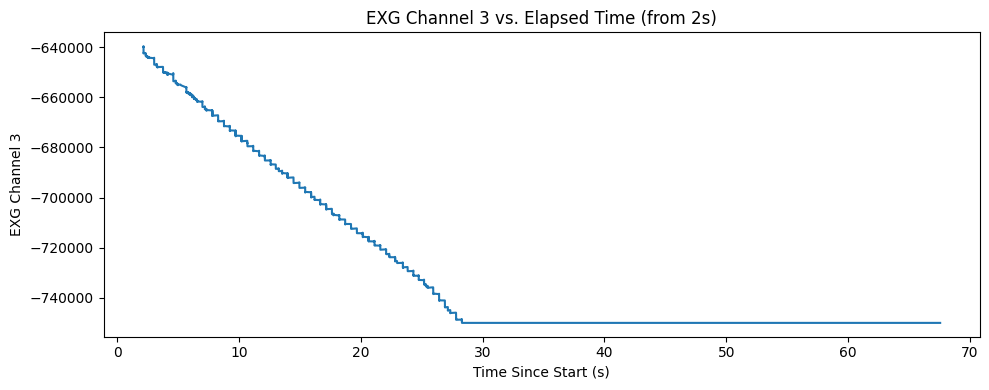

In [117]:
convert_openbci_txt_to_csv('Data/OpenBCI-RAW-2025-05-17_18-35-41.txt', 'Data/OpenBCI-RAW-2025-05-17_18-35-41.csv')
plt.show(plot_column_vs_elapsed_time('Data/OpenBCI-RAW-2025-05-17_18-35-41.csv', 'EXG Channel 3', 2))